<a href="https://colab.research.google.com/github/Carabinero/politeness-review-classification/blob/main/sentiment_analysis_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis and Prediction

Sentiment analysis is the process of understanding the opinion of an author about a subject.
Examples include analyzing movie ratings, amazon product reviews or the analysis of Twitter tweet sentiment.

For the purposes of this analysis we will:
- Explore our data
- Transform sentiment carrying columns
- Predict sentiment with a supervised machine learning model

In [1]:
%%capture
!pip install wordcloud

In [33]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
)
from wordcloud import WordCloud
from functools import reduce
from nltk import word_tokenize
from string import punctuation
import re



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# 1. Load your data
Upload data that has textual value and an indication of the sentiment (0 = negative, 1 = positive)

In [21]:
# Upload your data as CSV and load as a data frame
df = pd.read_csv('PolitenessDataset-FULL.csv')
print(df.shape)
df.head(100)

(2500, 5)


,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN
4,ShitMyReviewerSay,NaN,The figures are dishonest and not all that use...,2,NaN
...,...,...,...,...,...
95,ShitMyReviewerSay,NaN,"Please respond to the Reviewer 2's comments, w...",5,NaN
96,ShitMyReviewerSay,NaN,"This is a pretty trivial study, sample size is...",2,NaN
97,ShitMyReviewerSay,NaN,The study is largely descriptive in nature and...,3,NaN
98,ShitMyReviewerSay,NaN,this may eventually be a cited paper.,3,NaN


In [26]:
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()
# print(df.columns)
df_filt = df.drop(["Venue", "Review ID", "Review URL"], axis=1)
df_filt = df_filt.dropna(subset=["review"])
df_filt['review_pro'] = df_filt['review'].apply(preprocess)
df_filt = df_filt.drop(["review"], axis=1)
df_filt = df_filt.rename(columns={"review_pro": "review"})
df_filt = df_filt.rename(columns={"Tone": "tone"})
# print(df_filt.columns)
print(df_filt.shape)
print(df_filt.head(100))

(2499, 2)
    tone                                             review
0      2  it is early in the year but difficult to imagi...
1      2  you do not use the empirical data for the anal...
2      3  i understand that wikipedia is not the best so...
3      3  reviewer   the project can hardly be described...
4      2  the figures are dishonest and not all that useful
..   ...                                                ...
95     5  please respond to the reviewer   s comments wh...
96     2  this is a pretty trivial study sample size is ...
97     3  the study is largely descriptive in nature and...
98     3               this may eventually be a cited paper
99     2  reading this paper i am struck by the elegance...

[100 rows x 2 columns]


<ipython-input-26-6489cbf80cab>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['review_pro'] = df_filt['review'].apply(preprocess)


# 2. Word cloud and feature creation
Visualize words that carry meaning with a word cloud

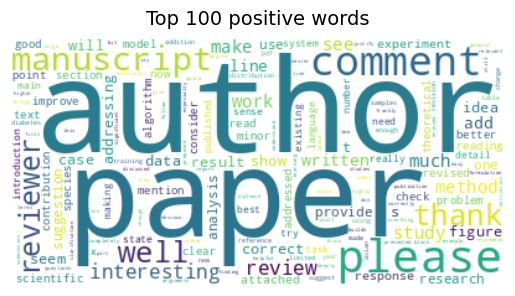

In [27]:
positive_df = df_filt[df_filt["tone"] == 5]["review"][:100]  # 1 = positive, 0 = negative
positive_df = reduce(lambda a, b: a + b, positive_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(positive_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 positive words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

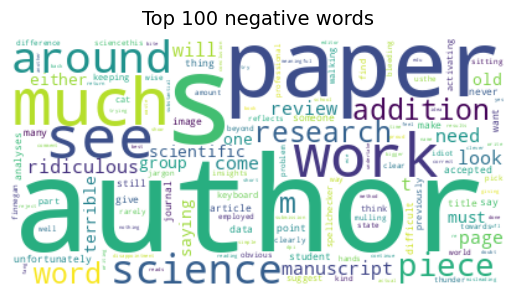

In [29]:
negative_df = df_filt[df_filt["tone"] == 1]["review"][:100]  # 1 = positive, 0 = negative
negative_df = reduce(lambda a, b: a + b, negative_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(negative_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 negative words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

In [36]:
# Tokenize each item in the review column
word_tokens = [word_tokenize(review) for review in df_filt["review"]]

# Create a new feature for the lengh of each review
df_filt["n_words"] = [len(word_tokens[i]) for i in range(len(word_tokens))]

df_filt

,tone,review,n_words
0,2,it is early in the year but difficult to imagi...,26
1,2,you do not use the empirical data for the anal...,16
2,3,i understand that wikipedia is not the best so...,36
3,3,reviewer the project can hardly be described...,21
4,2,the figures are dishonest and not all that useful,9
...,...,...,...
2495,2,the scientific contribution of this paper if t...,17
2496,2,reviewer the proposal is also poorly written...,16
2497,3,the paper could be considered for acceptance g...,20
2498,2,i don t see how your approach has potential to...,19


# 3. Building a vectorizer
Use the Tfidf Vectorizer to transform the data into numerical values that can be used to make predictions.

In [37]:
# Build the vectorizer
vect = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    max_features=200,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

vect.fit(df_filt.review)

# Create sparse matrix from the vectorizer
X = vect.transform(df_filt.review)

# Create a DataFrame
df_transformed = pd.DataFrame(data=X.toarray(), columns=vect.get_feature_names_out())
df_transformed

,abstract,accepted,actually,add,addressed,al,algorithm,analysis,approach,architecture,...,used,useful,using,version,way,weak,weights,work,writing,written
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.478763,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2495,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499248
2496,0.529755,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2497,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.525129,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# 4. Building a classifier
Use a logistic regression to predict the sentiment of unseen data.
Visualize the errors your classifier makes with a confusion matrix.

In [50]:
dropped = df_filt.drop(["review", "n_words"], axis=1)
transformed = pd.concat([dropped, df_transformed], axis=1)
transformed
transformed = transformed.dropna()
transformed

,tone,abstract,accepted,actually,add,addressed,al,algorithm,analysis,approach,...,used,useful,using,version,way,weak,weights,work,writing,written
0,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.478763,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2495,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499248
2496,2.0,0.529755,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2497,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.525129,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [53]:
# Define X and y
y = transformed["tone"]
X = transformed.drop("tone", axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

# Train a logistic regression
log_reg = LogisticRegression().fit(X_train, y_train)

# Predict the labels
y_predicted = log_reg.predict(X_test)

# Print accuracy score and confusion matrix on test set
print("Accuracy on the test set: ", accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted) / len(y_test))

Accuracy on the test set:  0.438
[[0.004 0.024 0.05  0.006 0.   ]
 [0.006 0.052 0.158 0.016 0.   ]
 [0.002 0.068 0.352 0.036 0.   ]
 [0.    0.022 0.134 0.03  0.   ]
 [0.    0.006 0.018 0.016 0.   ]]


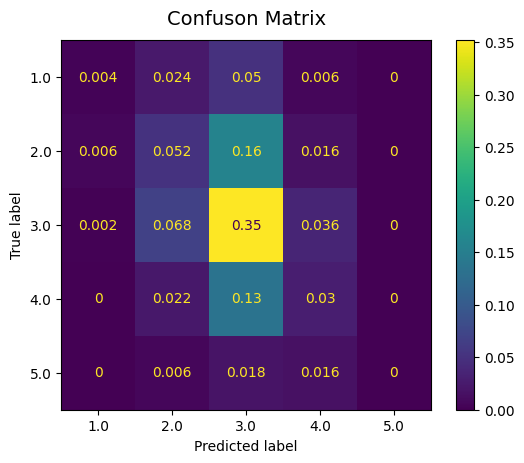

In [54]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, normalize="all")
plt.title("Confuson Matrix", y=1.02, size=14)
plt.show()